In [46]:
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T
from sklearn import metrics
import seaborn as sns
import time
import math
import numpy as np
import matplotlib.pyplot as plt

In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [48]:
transform = T.Compose(
    [T.Resize(224),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    test_set, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
def get_model_mobilenet_cifar10():
  model = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)
  model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 10)
  model = model.to(device)
  # print(model)
  return model

In [50]:
import time
import math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [51]:
# Train the model
def model_training(model,criterion,optimizer,trainloader,testloader,num_epochs = 10):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(labels.cpu().detach().numpy(),outputs.cpu().detach().numpy().argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            images, labels = next(iter(testloader))
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += metrics.accuracy_score(labels.cpu().detach().numpy(),outputs.cpu().detach().numpy().argmax(axis=1))
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss
        train_acc = train_acc/len(trainloader)
        val_acc = val_acc
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    print(f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list),time.time()-start,loss_list[-1][2],loss_list[-1][3]

In [52]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(Y_test,Y_pred_probs,k=5,labels=np.arange(10))

    plt.figure(figsize=(10, 10))
    plt.title(f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')

In [53]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize =(20,7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:,0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:,2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:,3], linestyle='-', label="Validation Accuracy" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()

Epoch: 1 (4m 12s) 	Training Loss: 0.998, 	Test Loss: 0.415,  	Training acc: 0.71, 	Test acc: 0.84, 
Epoch: 2 (8m 19s) 	Training Loss: 0.385, 	Test Loss: 0.259,  	Training acc: 0.87, 	Test acc: 0.91, 
Epoch: 3 (12m 29s) 	Training Loss: 0.280, 	Test Loss: 0.132,  	Training acc: 0.91, 	Test acc: 0.97, 
Epoch: 4 (16m 34s) 	Training Loss: 0.216, 	Test Loss: 0.145,  	Training acc: 0.93, 	Test acc: 0.91, 
Epoch: 5 (20m 40s) 	Training Loss: 0.171, 	Test Loss: 0.324,  	Training acc: 0.94, 	Test acc: 0.84, 
Epoch: 6 (24m 47s) 	Training Loss: 0.135, 	Test Loss: 0.297,  	Training acc: 0.96, 	Test acc: 0.88, 
Epoch: 7 (28m 53s) 	Training Loss: 0.108, 	Test Loss: 0.408,  	Training acc: 0.97, 	Test acc: 0.88, 
Epoch: 8 (32m 59s) 	Training Loss: 0.085, 	Test Loss: 0.424,  	Training acc: 0.97, 	Test acc: 0.84, 
Epoch: 9 (37m 5s) 	Training Loss: 0.067, 	Test Loss: 0.151,  	Training acc: 0.98, 	Test acc: 0.91, 
Epoch: 10 (41m 11s) 	Training Loss: 0.052, 	Test Loss: 0.228,  	Training acc: 0.99, 	Test acc:

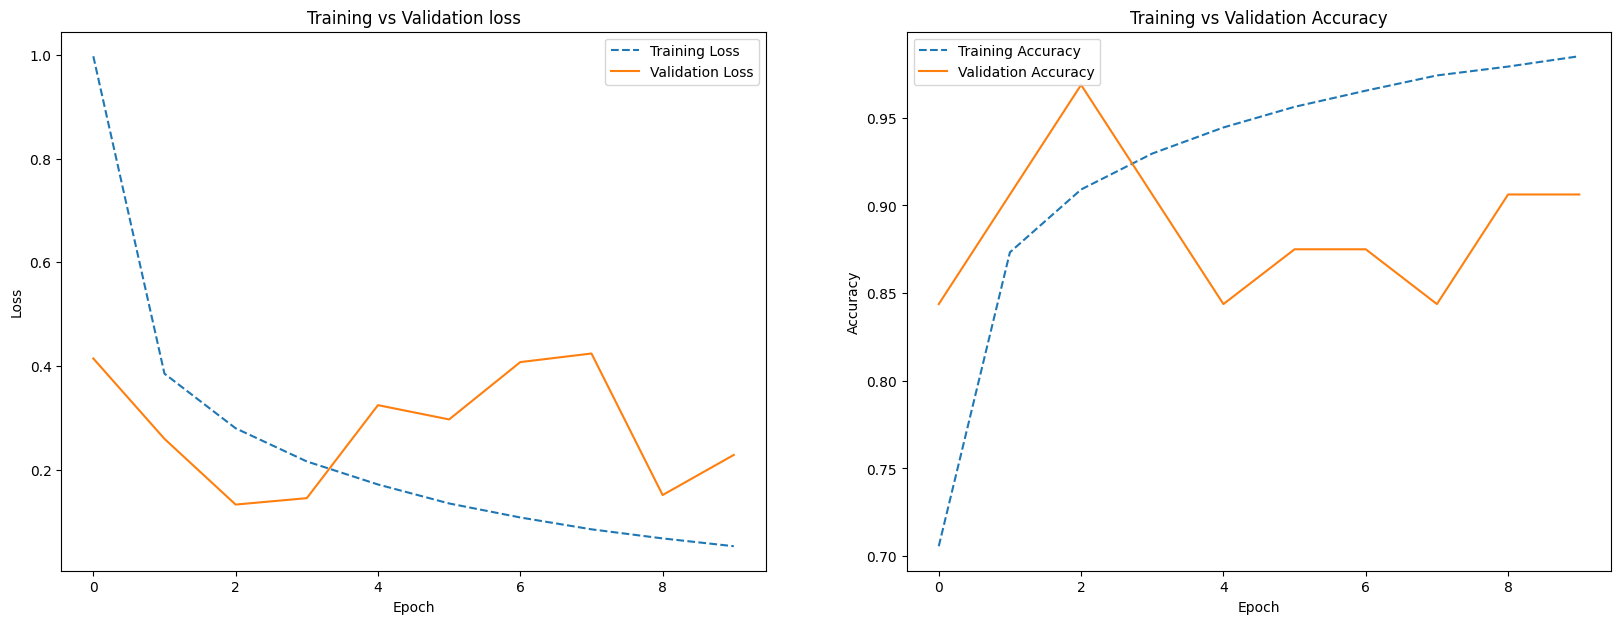

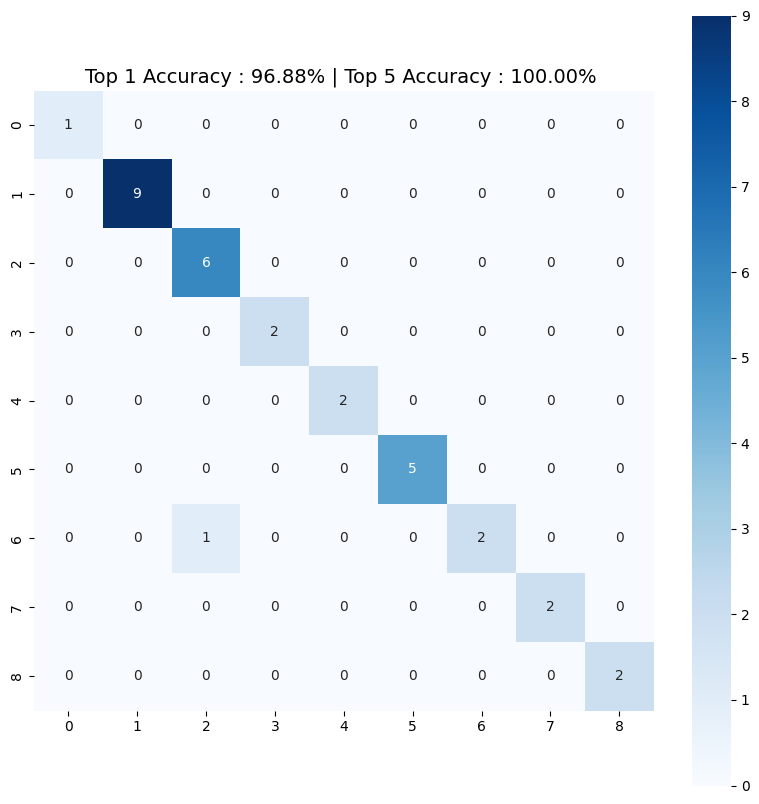

Top 1 Accuracy: 96.875%
Top 5 Accuracy: 100.0%
Classwise Accuracy Score: 
[1.         1.         1.         1.         1.         1.
 0.66666667 1.         1.        ]


In [59]:
model = get_model_mobilenet_cifar10()
optimizer =  torch.optim.Adam(model.parameters(), lr=0.000001)
criterion = torch.nn.CrossEntropyLoss()
loss_list,t,train_a,test_a = model_training(model,criterion,optimizer,trainloader,testloader,num_epochs=10)
plot_training_graphs(loss_list)
test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_output = model(test_images)
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels.cpu(),test_output.cpu(),test_set.classes)